In [1]:
from astroquery.gaia import Gaia
import importlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../')

from astroLuSt.database_interface import gaiainterface as aldiga
from astroLuSt.database_interface import simbadinterface as aldisi
from astroLuSt.styles import plot_styles as alstps

importlib.reload(aldiga)
importlib.reload(alstps)

#style for plotting
_ = alstps.tre_light()


# GaiaDatabaseInterface

In [2]:
targets = [
    'KIC 5006817', 'RR Lyr', 'TV Boo', 'KIC 5006817',
    'TIC 100015323'
]


SDI = aldisi.SimbadDatabaseInterface(n_jobs=1, simbad_timeout=120)

df_ids = SDI.get_ids(input_ids=targets)

#extract relevant IDs
df_ids = df_ids['ids'].str.extractall(pat=(
    r'(?P<id_gaiadr3>Gaia DR3[^|\n]+)'
    r'|(?P<id_tic>TIC[^|\n]+)'
)).groupby(level=0).first()

display(df_ids)

,id_gaiadr3,id_tic
0,Gaia DR3 2101103743584479744,TIC 122447138
1,Gaia DR3 2125982599343482624,TIC 159717514
2,Gaia DR3 1492230556717187456,TIC 168709463
3,Gaia DR3 2101103743584479744,TIC 122447138
4,Gaia DR3 4959612046243236864,TIC 100015323


GaiaDatabaseInterface(
    gaia_class=Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443,
    verbose=0,
)


/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


dict_keys(['EPOCH_PHOTOMETRY-Gaia DR3 1492230556717187456.xml', 'EPOCH_PHOTOMETRY-Gaia DR3 2125982599343482624.xml', 'MCMC_GSPPHOT-Gaia DR3 2125982599343482624.xml'])
Index(['source_id', 'transit_id', 'band', 'time', 'mag', 'flux', 'flux_error',
       'flux_over_error', 'rejected_by_photometry', 'rejected_by_variability',
       'other_flags', 'solution_id', 'flux_normalized'],
      dtype='object')
band
G     73
BP    73
RP    73
Name: count, dtype: int64
1.0


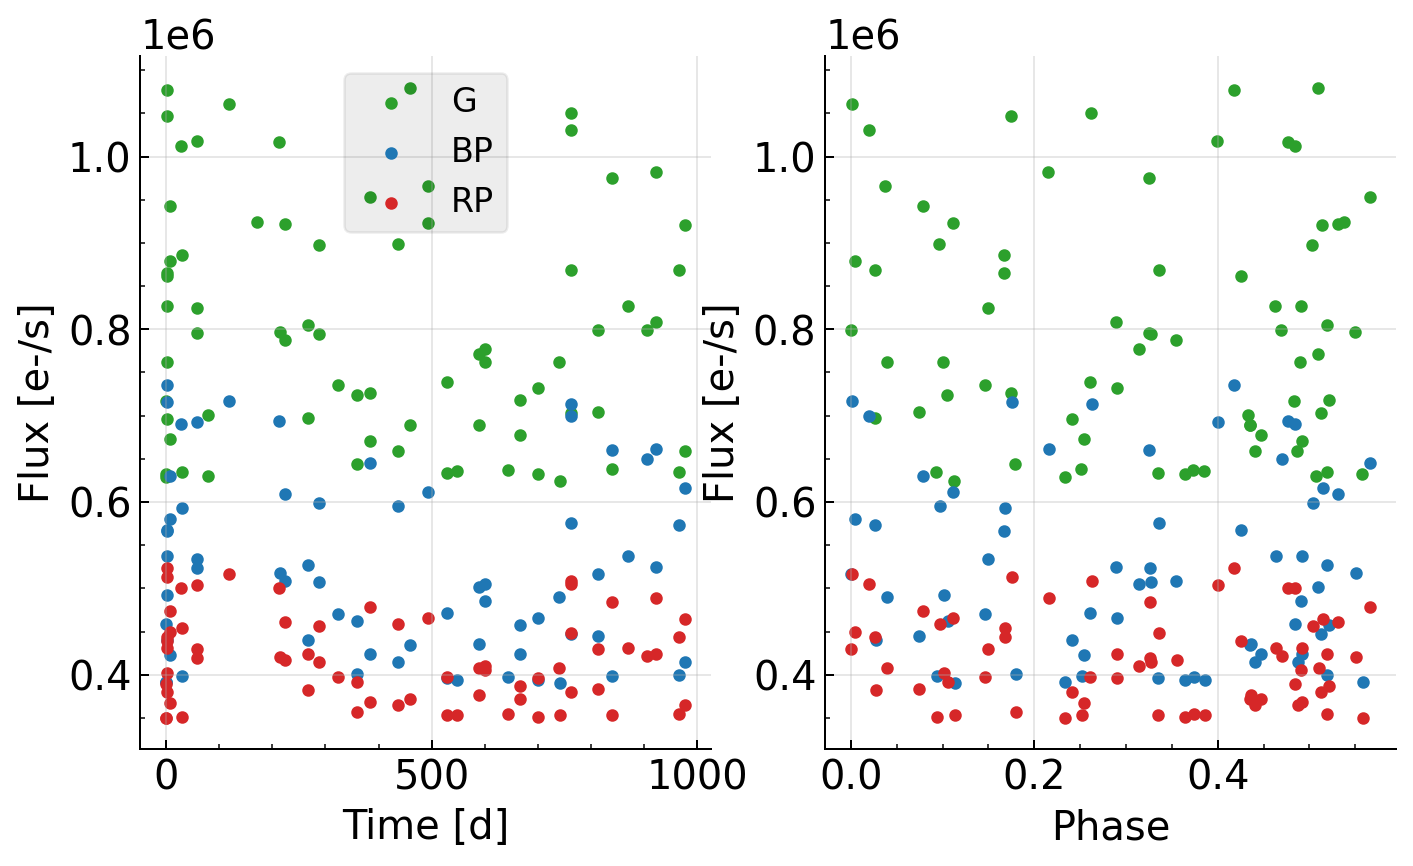

In [3]:
importlib.reload(aldiga)

GDI = aldiga.GaiaDatabaseInterface(
    gaia_class=Gaia,
    verbose=0
)
print(GDI)


# filter = "(jobs['phase'] == 'ERROR')"
# GDI.remove_all_jobs(pd_filter=filter, login_before=False, logout_after=False)


# print(df_ids.keys)
res = GDI.get_datalink(
    ids=df_ids['id_gaiadr3'],
    normfunc=lambda x, df: x/np.nanmedian(x),
    retrieval_type=['EPOCH_PHOTOMETRY','MCMC_GSPPHOT'],
    # retrieval_type=['ALL'],
    n_chunks=2,
    load_data_kwargs=dict(
        data_release='Gaia DR3',
        format='votable',
    ),
    save_kwargs=dict(directory='../_data/')
)



df = res[list(res.keys())[0]]
print(res.keys())

print(df.columns)


print(df['band'].value_counts())

df['phase'] = df['time']%0.56666
df['time'] -= df['time'].min()

print(df.query('band=="G"')['flux_normalized'].median())

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(*df.query('band=="G"')[[ 'time', 'flux']].values.T, c='tab:green', label='G')
ax1.scatter(*df.query('band=="BP"')[['time', 'flux']].values.T, c='tab:blue',  label='BP')
ax1.scatter(*df.query('band=="RP"')[['time', 'flux']].values.T, c='tab:red',   label='RP')
ax2.scatter(*df.query('band=="G"')[[ 'phase','flux']].values.T, c='tab:green', label='G')
ax2.scatter(*df.query('band=="BP"')[['phase','flux']].values.T, c='tab:blue',  label='BP')
ax2.scatter(*df.query('band=="RP"')[['phase','flux']].values.T, c='tab:red',   label='RP')

ax1.set_xlabel('Time [d]')
ax2.set_xlabel('Phase')
ax1.set_ylabel('Flux [e-/s]')
ax2.set_ylabel('Flux [e-/s]')
ax1.legend()


# print(res)
